In [1]:
import numpy as np
from scipy.special import gammainc, gamma
import matplotlib.pyplot as plt
from scipy.special import factorial
from scipy.integrate import quad
from scipy.stats import poisson
from tqdm import tqdm   
from random import choices
from collections import Counter
from scipy.optimize import curve_fit

## Juan Notes:
* I would like a docstring for how singleAtom works. We've been using the google standard for dev on the cspy project, looks like we'll be adopting it as a lab so use that.
    - google standard styleguide, info on docstrings is section 3.8 : http://google.github.io/styleguide/pyguide.html
    - google standard examples : https://sphinxcontrib-napoleon.readthedocs.io/en/latest/example_google.html
* Could you be more detailed in your explanation of the math? It's ok if you're starting from a near transcription of Mark's notes

The rate of photon emission from a single atom is a poisson distribution centerred around the mean number of counts, rateSingleAtom*recordTime.
However, the readout beams can heat the atom in the trap and so there is a finite lifetime of the trap
$$\frac{e^{-t/\tau}}{\tau}$$ where $\tau$ is the lifetimeOfTrap.

The function singleAtom finds the new probability distribution integrating the lifetime with the poisson distribution from start of readout to end of readout. 

We then have to convolve the single atom rate with the background rate because the background rate is always present. From wikipedia:  

"the probability mass function or probability density function of a sum of random variables is the convolution of their corresponding probability mass functions or probability density functions respectively"

the sum here is the background rate and the single atom rate.

In [2]:
def convolve(dist1,dist2):
    new = np.zeros_like(dist1)
    
    for n in range(len(new)):
        val = 0
        for m in range(n):
            val = val + dist1[m]*dist2[n-1-m]      
            new[n] = val

    return new

def singleAtom(recordTime,rate,lifeTime,xx):
    """
    analytically evaluates the probability distribution of photon counts n (xx[n]) for a single atom in a dipole trap
    Args:
        recordTime: the time that the measurment beams are active(seconds).
        rate: the rate that the single atom emits photons(photons/second)
        lifeTime: the lifetime of the trap(seconds)
        xx: an array of integers that are the possible photon counts to measure
    Returns:
        an array of probabilities to measure the photon count given the paramaters.

    """ 
    prob = [] 
    #go through all of the photon counts in xx
    for i in tqdm(xx):
        #take the integral of the lifetime and the poisson dist 
        val = quad(
            lambda t,r,n,tau:np.exp(-t/tau)/tau*poisson.pmf(n,r*t),
            0,
            recordTime,
            args = (rate,i,lifeTime) 
        )[0] 
        prob.append(val+np.exp(-recordTime/lifeTime)*poisson.pmf(i,rate*recordTime)) #add in the 

    
    return prob



These are just functions that I have defined because they are used in multiple places

* getHistogram i use to run the experiments when given a background and single atom probability function for photon counts
* gaussian1 or gaussian2 are used for fitting
* graph does a lot, it graphs the data into a histogram and then fits the data and returns that fit



In [3]:
def getHistogram(probDistBack,probDistSingle,dataPoints = 5000,samples = [], weights = [.5,.5]):
    """
    calcuates an array of counts given the background and atom distributions
    Args:
        probDistBack: the background probability distribution
        probDistSingle: the single atom probability distribution
        dataPoints: the amount of times to run the experiemnt
        samples: an array of length boolean values that represent if that atom is trapped or not
        weights: the loading proability for 0,1 atoms
    Returns:
        an array of values that are ready for a histogram

    """ 
    hist = [] 
    population = [False,True] #false is no atom, true is single atome
    #check to see if we are supplied with any samples, if not generate with dataPoiints
    if len(samples) == 0:   
        samples = choices(population,weights,k = dataPoints)

    for i in samples:
        if not i:
            #do background rate
            hist.append(choices(xx,probDistBack)[0])
        else:
            #do single atom rate
            hist.append(choices(xx,probDistSingle)[0])
    return hist

In [4]:
#the function for scipy curve fit as the addition of two gaussian curves
def gaussian2(x, amp1,cen1,sigma1,amp2,cen2,sigma2):
    """ 
    a function of the addition of two gaussians
    Args:
        x: position to evaluate the function at
        amp1: the amplitude of the first gaussian function
        cen1: the center of the first gaussian function
        sigma1: the standard deviation of the first gaussian function
        amp2: the amplitude of the second gaussian function
        cen2: the center of the second gaussian function
        sigma2: the standard deviation of the second gaussian function
    Returns:
        the value of the double gaussian at position x

    """
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + \
            amp2*(1/(sigma2*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen2)/sigma2)**2)))
def gaussian1(x, amp1,cen1,sigma1):
    """ 
    a function of the addition of one gaussians
    Args:
        x: position to evaluate the function at
        amp1: the amplitude of the first gaussian function
        cen1: the center of the first gaussian function
        sigma1: the standard deviation of the first gaussian function
       
    Returns:
        the value of the single gaussian at position x

    """
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2)))
            
def graph(histogram, p0 = [],binNumber = 50, colors = ["gray", "red"],fit = True,double = True):
    """ 
    Args:
        histogram: the dist of data to put in the histogram
    Kwargs:  
        p0: a list of the initial guesses of for the scipy curve fit function on two gaussian functions 
            [amplitude1,center1,sigma1,amplitude2,center2,sigma2]     
        binNumnber: the number of bins in the histogram
        colors: a list of the colors for the histogram chart and fit line
        fit: a boolean that when true graphs a fit from the p0 values
        Double: a boolean that when true fits a double gaussian to the data
    Returns:
        returns the y values of the fit for the given range of the histogram data, if no fit is given then an 
        empty array is returned
    """
    #the histogram and the bin heights and centers that will be used for fitting
    bin_heights, bin_borders, _ = plt.hist(histogram,binNumber,color = colors[0])

    if fit:
        bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
        #fit with guess p0
       
        x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
        if double:
            popt, pcov = curve_fit(gaussian2, bin_centers, bin_heights, p0)
            plt.plot(x_interval_for_fit, gaussian2(x_interval_for_fit, *popt), 
                label=r"$\mu_1$ = %.2f std = %.2f $\mu_1$ = %.2f std = %.2f"%(
                    popt[1],popt[2],popt[4],popt[5]),color = colors[1]
                    )
        else:
            popt, pcov = curve_fit(gaussian1, bin_centers, bin_heights, p0)
            plt.plot(x_interval_for_fit, gaussian1(x_interval_for_fit, *popt), label=r"$\mu_1$ = %.2f and std = %.2f"%(popt[1],popt[2]),color = colors[1])
        plt.legend()    
    
    plt.xlabel("Photon Counts")
    plt.ylabel("Frequency of Counts")
    plt.show()
    if not fit:
        return []
    if not double:
        return gaussian1(xx,*popt)
    else:
        return gaussian2(xx,*popt)


Here is where I am now running the analytical solution and graphing it

100%|██████████| 900/900 [00:12<00:00, 72.66it/s]


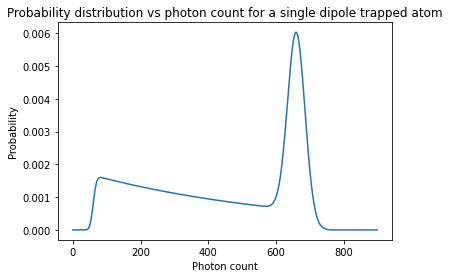

In [5]:
#define the variables that determine how many photons are released
recordTime = .003*0+60*10**-3  #s
rateSingleAtom = 145000*0+10*10**3  #Hz
rateBackground = 10000*0+1*10**3  #Hz
lifetimeOfTrap =  0*10000+60*10**-3  #s
#up to this many photons
countEnd = 900
xx = np.arange(countEnd)
#the background is just a poisson distribution
probDistBack = poisson.pmf(xx,recordTime*rateBackground)
#get the distribution, the integrals take longer then the rest of the code
probDistSingle = singleAtom(recordTime,rateSingleAtom,lifetimeOfTrap,xx)
#now convolve with background rate
probDistSingle = convolve(probDistBack,probDistSingle)
plt.plot(xx,probDistSingle)
plt.title("Probability distribution vs photon count for a single dipole trapped atom")
plt.xlabel("Photon count")
plt.ylabel("Probability")
plt.show()

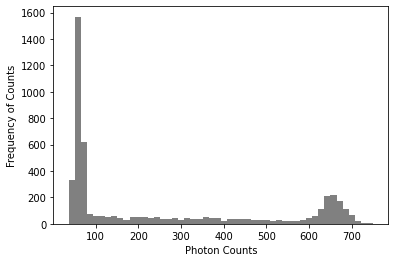

Background mean(rate*time): 60.00


In [6]:
hist = getHistogram(probDistBack,probDistSingle)
graph(hist,p0=[1000, 50, 1, 400, 600, 5],fit = False)
print ("Background mean(rate*time): %.2f" %(recordTime*rateBackground))

The integration takes a long time, this is my attempt at simulating atom loss during a measurement many times. Instead of taking an integral for each photon count, take the probability of the atom leaving the trap at time t for t from 0 to recorded time. At each of the steps change the probability that the atom will leave, then count up the amount of photons according to the status of the atom at that step(rate/totalTimeSteps). I tried taking a new sample from each dist at each step but that only created two very distinct gaussian dist far apart. I think that is interesting and it might have something to do with normal distrbutions and sample numbers. 

In [7]:
def simulateAtomLoss(recordTime,trapLifetime,xx,probDistSingle,probDistBack,totalTimeSteps = 1000):
    """ 
    simulates an atom being lossed during readout with given trap paramaters 
    Args:
        recordTime: the time that the measurment beams are active(seconds).
        trapLifetime: the lifetime of the trap(seconds)
        xx: an array of integers that are the possible photon counts to measure
        probDistBack: the background probability distribution
        probDistSingle: the single atom probability distribution
    Returns:
        an array of probability distribution for a single atom 
    """
    time_bins = np.linspace(0,recordTime,totalTimeSteps)
    #the dist of the atom in the trap 
    #normalize = 2*lifetimeOfTrap*np.exp(2*recordTime/trapLifetime)/(np.exp(2*recordTime/trapLifetime)-1)
    time_dist = [np.exp(-t/trapLifetime)/trapLifetime for t in time_bins]
    time_dist = time_dist/max(time_dist)
    
    #so given each time step, there is a chance 1-time_dist[step] of leaving the trap
    #each step there is a poisson dist of photons emiited that is divided by nTimeSteps
    probDist = []
    atomLeft = False
    count = np.zeros_like(xx)
    experiments = 500
    dist = convolve(probDistSingle,probDistBack)
    for e in tqdm(range(experiments)):
        nPhotons = 0
        randomBack = choices(xx,probDistBack,k=totalTimeSteps)
        #randomeSingle = choices(xx,probDistSingle,k=totalTimeSteps)
        random = choices(xx,dist,k = totalTimeSteps)
        atomLeft = False
        for i,t in enumerate(time_dist):
            w = [1-t,t]
            if not atomLeft and choices([False,True],weights=w)[0]:
                nPhotons = nPhotons + random[i]
            else:
                #atomleft = True
                pass
               # nPhotons = nPhotons + randomBack[i]
        probDist.append(nPhotons/totalTimeSteps)

    #now get the fit of the line, it is a gaussian

    return probDist



* The problem I am having is the fact that the simulation is just a poission distribution, I need that exponential tail like that of the analytical function.

* The standard deviation gets smaller with more experiments, I think that shows that the way I am having that atoms leave the trap is not right.

* There needs to be photon count values that are not clustered around the mean, there should be atoms leaving the trap and only producing the background rate. Instead, they are just averaging out to the same values, the background rate just moves the median.



100%|██████████| 500/500 [00:02<00:00, 247.82it/s]


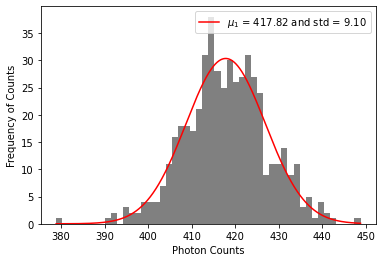

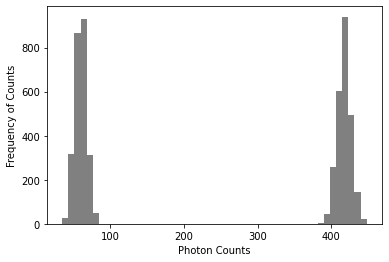

'plt.show()\nplt.plot(xx,probDistSingle)'

In [8]:
test = poisson.pmf(xx,(rateSingleAtom)*recordTime)
probDistSimulated = simulateAtomLoss(recordTime,lifetimeOfTrap,xx,test,probDistBack)
fitValues = graph(probDistSimulated,p0 = [30,420,2],double = False)
h = getHistogram(probDistBack,fitValues)
graph(h,fit = False)
"""plt.show()
plt.plot(xx,probDistSingle)"""